In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install ydata-synthetic lib
! pip install ydata-synthetic

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/223 Project') # customize this line to your working directory

Mounted at /content/drive


# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [ ]:
# Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ydata_synthetic.synthesizers import ModelParameters, TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x79e603229a20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1014, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1184, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so: cannot open shared object file: No such file or directory


## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [ ]:
# Specific to TimeGANs
seq_len = 24
n_seq = 2
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
# For quick prototyping
# epochs=50000
epochs = 500

gan_args = ModelParameters(
    batch_size=batch_size, lr=learning_rate, noise_dim=noise_dim, layers_dim=dim
)

train_args = TrainParameters(
    epochs=epochs, sequence_length=seq_len, number_sequences=n_seq
)

## The data

In [ ]:
data_path = 'sliced_data_pca.csv'
stock_data = pd.read_csv(data_path)
cols = list(stock_data.columns)
print(stock_data.shape)

(3809, 2)


In [ ]:
stock_data.head()

,0,1
0,-2.501627,-0.076127
1,-2.497598,-0.077010
2,-2.493814,-0.078400
3,-2.490701,-0.078775
4,-2.487373,-0.078597


## Training the TimeGAN synthetizer

In [ ]:
if path.exists("pca_synthesizer_stock.pkl"):
    synth = TimeSeriesSynthesizer.load("pca_synthesizer_stock.pkl")
else:
    synth = TimeSeriesSynthesizer(modelname="timegan", model_parameters=gan_args)
    synth.fit(stock_data, train_args, num_cols=cols)
    synth.save("pca_synthesizer_stock.pkl")

### The generated synthetic stock data

In [ ]:
stock_data_blocks = processed_stock(path=data_path, seq_len=seq_len)
synth_data = np.asarray(synth.sample(len(stock_data_blocks)))
print(synth_data.shape)

(3785, 24, 2)


In [ ]:
synths = []
for i in range(len(synth_data)):
  for j in range(23):
    synths.append(synth_data[i][j])


array([0.1008867 , 0.24277942], dtype=float32)

In [ ]:
synth_df = pd.DataFrame(synths)
synth_df.to_csv('synth_data.csv')
!cp synth_data.csv '/content/drive/MyDrive/223 Project'

cp: 'synth_data.csv' and '/content/drive/MyDrive/223 Project/synth_data.csv' are the same file


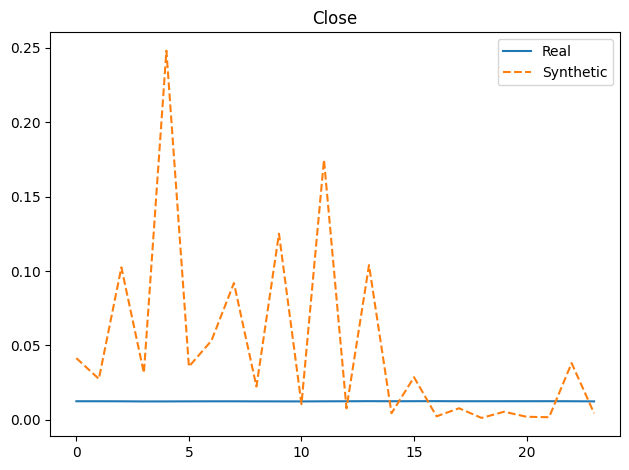

In [ ]:

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots()

time = list(range(1,25))
obs = np.random.randint(len(stock_data_blocks))
real = stock_data_blocks[obs]
synth = synth_data[obs]
new_real = []
new_synth = []
for i in range(len(real)):
  new_real.append(real[i][0])
for i in range(len(synth)):
  new_synth.append(synth[i][0])

df = pd.DataFrame({'Real': new_real,'Synthetic': new_synth})
df.plot(ax=axes,
            title = "Close",
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data_blocks))[:sample_size]

real_sample = np.asarray(stock_data_blocks)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
stock_data_reduced = real_sample.reshape(-1, seq_len)
synth_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

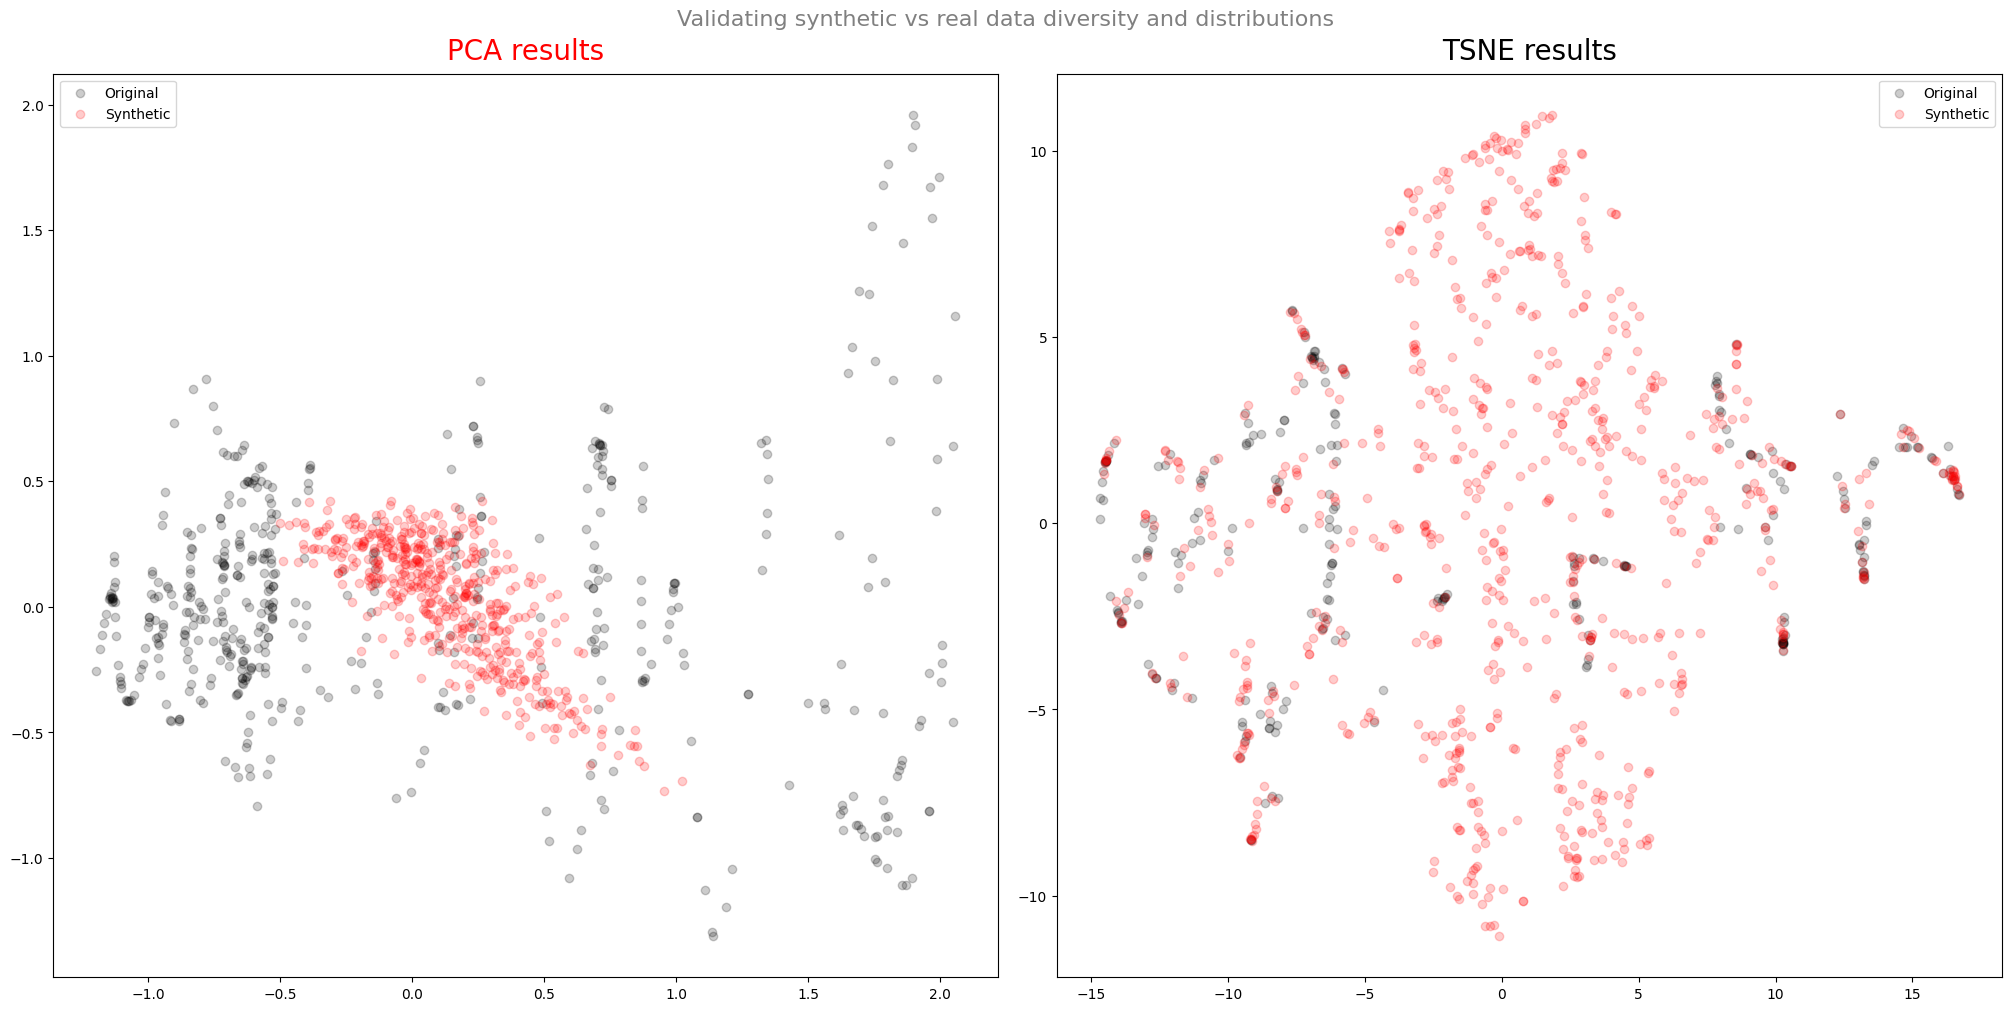

In [ ]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='black',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [ ]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=1,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [ ]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data_blocks)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (18120, 23, 1)
Real X train: (18120, 23, 1)
Synthetic y train: (18120, 1)
Real y train: (18120, 1)
Real X test: (6040, 23, 1)
Real y test: (6040, 1)


In [ ]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
142/142 [==============================] - 14s 53ms/step - loss: 0.2249 - val_loss: 0.1086
Epoch 2/200
142/142 [==============================] - 5s 34ms/step - loss: 0.1089 - val_loss: 0.1068
Epoch 3/200
142/142 [==============================] - 6s 44ms/step - loss: 0.0556 - val_loss: 0.0221
Epoch 4/200
142/142 [==============================] - 4s 30ms/step - loss: 0.0185 - val_loss: 0.0160
Epoch 5/200
142/142 [==============================] - 2s 16ms/step - loss: 0.0137 - val_loss: 0.0104
Epoch 6/200
142/142 [==============================] - 2s 17ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 7/200
142/142 [==============================] - 2s 16ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 8/200
142/142 [==============================] - 3s 18ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 9/200
142/142 [==============================] - 3s 23ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/200
142/142 [==============================] - 2s 15ms/step - loss: 0.00

In [ ]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
142/142 [==============================] - 7s 28ms/step - loss: 0.2264 - val_loss: 0.1101
Epoch 2/200
142/142 [==============================] - 2s 16ms/step - loss: 0.0920 - val_loss: 0.1104


In [ ]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results


189/189 [==============================] - 1s 4ms/step


,r2,MAE,MRLE
Real,0.999395,0.002325,0.000009
Synthetic,-0.267964,0.110394,0.027957
